In [3]:

def load_gene_names():
    ret = set()
    syns = {}

    with open('genenames.txt') as f:
        c = 0
        for l in f:
            c += 1
            if c == 1:
                header = l.split('\t')
                syn_index = header.index('Synonyms')
                symb_index = header.index('Previous Symbols')
                continue
                
            ls = l.split('\t')
            gene = ls[1]
            ret.add(gene)
            this_syn = [x.strip() for x in ls[syn_index].split(',')]
            for x in this_syn:
                syns[x] = gene
            
            symbols = [x.strip() for x in ls[symb_index].split(',')]
            for x in symbols:
                syns[x] = gene
            
            
    return {x: None for x in ret}, syns

stop = {
    '2': None,
    'T': None,
    'B': None,
}

def check_gene_name(x):
    
    if x in stop:
        return None
    
    if x in genenames:
        if not 'realnames' in stats:
            stats['realnames'] = 0
        stats['realnames'] += 1
        
        return x
    
    if x in genesyns:
        
        if not 'syns' in stats:
            stats['syns'] = 0
        stats['syns'] += 1
        
        return genesyns[x]
    
    extra_synonyms = {
        # Found : Real
        'FXII': 'F12',
    }
    
    if x in extra_synonyms:
        return extra_synonyms[x]
    
    if x.lower() in ['mitochondrial', 'mtdna']:
        
        if not 'mitochondrial' in stats:
            stats['mitochondrial'] = 0
        stats['mitochondrial'] += 1
        
        return 'mtdna'
    
    return None


In [4]:
genenames, genesyns = load_gene_names()

In [9]:
genenames['BRCA2']

In [10]:
genesyns['HPRT']

KeyError: 'HPRT'

In [18]:
import re
import json
import codecs

stats = {}

def gen_abstracts(filename, per=100):
    abstract_counter = 0
    hgvs_counter = 0
    with open(filename) as f:
        for l in f:
                        
            data = json.loads(l)
            for result in data['resultList']['result']:
                
                if not 'pubmedcounter' in stats:
                    stats['pubmedcounter'] = 0
                stats['pubmedcounter'] += 1
                
                if 'abstractText'in result:
                    abstract = result['abstractText']
                    abstract_counter += 1
                    if abstract_counter % per == 0:
                        print ('Abstract counter:', abstract_counter)
                        
                    if not 'abstractcounter' in stats:
                        stats['abstractcounter'] = 0
                    stats['abstractcounter'] += 1
                        
                    #if 'NM_' in abstract:
                    #    print (abstract)
                    #    assert False
                    yield abstract
                else:
                    if not 'noabstract' in stats:
                        stats['noabstract'] = 0
                    stats['noabstract'] += 1

def gen_hgvs(filename):
    hgvs_counter = 0
    
    for abstract in gen_abstracts(filename):
        
        transcripts = get_transcripts(abstract)
        
        for hgvs in gen_hgvs_2(abstract):
            hgvs_counter += 1

            if hgvs_counter % 100 == 0:
                print ('HGVS FOUND:', hgvs_counter)
            
            gene = get_gene_names(abstract, hgvs[1])
            
            yield abstract, gene, ''.join(hgvs), transcripts

def get_gene_names(abstract, hgvs):
    pos = abstract.index(hgvs)
    
    before = abstract[:pos]
    after = abstract[pos+len(hgvs):]
    
    #Check before
    before = before.split()[::-1]
    before = [noparenthesis(x) for x in before]
    
    for word in before:
        name = check_gene_name(word)
        if name:
            return name
    
    #Check after
    after = [noparenthesis(x) for x in after.split()]
    for word in after:
        name = check_gene_name(word)
        if name:
            return name
    
    if not 'no_gene' in stats:
        stats['no_gene'] = 0
        
    stats['no_gene'] += 1
    
    #print abstract
    #print hgvs
    
    #if stats['no_gene'] > 1:
    #    assert False
    return None

def gen_hgvs_2(abstract):
    #245 A>
    #found = re.findall(r'(.{1,100})([\d]+[\s]*[ACGT]+[\s]*>)(.{1,100})',abstract, re.UNICODE)
    found = re.findall(r'[\d]+[\s]*[ACGT]+[\s]*>',abstract, re.UNICODE)
    
    if not found:
        if not 'nohgvs' in stats:
            stats['nohgvs'] = 0
        stats['nohgvs'] += 1
    
    for f in found:
        start = abstract.index(f)
        before = abstract[:start]
        after = abstract[start+len(f):]
        
        # We do not want any HGVS before and after the one that we found
        before = before.replace('>','')
        after = after.replace('>', '')

        yield before, f, after
    

def get_transcripts(text):
    return re.findall(r'[A-Z][A-Z]_[\d]{4,15}\.?[\d]*', text, re.UNICODE)
        
def nowhite(p):
    return re.sub(r'[\s]', '', p, flags=re.UNICODE)

def noparenthesis(p):
    return re.sub(r'[\(\),\.\:]', '', p, flags=re.UNICODE)

def post_process(hgvs):

    s = None
    
    if not s:
        # c.6348+1G>A
        s = re.search(r'[CcGgpP][\s]*\.[\s]*[\d]+[\s]*[\+\-][\s]*[\d]+[\s]*[ACGT]+[\s]*>[\s]*[ACGT]+', hgvs, re.UNICODE)
    
    if not s:
        # c.969C > A
        s = re.search(r'[CcGgpPm][\s]*\.[\s]*[\d]+[\s]*[ACGT][\s]*>[\s]*[ACGTS]+', hgvs, re.UNICODE)
    
    if not s:
        # 236G > A
        s = re.search(r'[\d]+[\s]*[ACGT]+[\s]*>[\s]*[ACGT]+', hgvs, re.UNICODE)
    
    if not s:
        # c.743C > del 
        s = re.search(r'[cCgGpP]\.[\d]+[ACGT]+[\s]*>[\s]*del', hgvs, re.UNICODE)
    
    #print ('=====')
    if s:
        result = nowhite(s.group(0))
        #print (hgvs)
        #print (result)
        return result
    else:
        #print (hgvs)
        #assert False
        
        if not 'noparsehgvs' in stats:
            stats['noparsehgvs'] = 0
        stats['noparsehgvs'] += 1
        
        return None
        
        
def do_1():
    output_fn = 'parsed_abstracts.json'
    output_f = codecs.open(output_fn, 'w', 'utf-8')
    records = 0
    for abstract, gene, hgvs, transcripts in gen_hgvs('abstracts.json'):
        hgvs = post_process(hgvs)
        if hgvs is None:
            continue

        
        records += 1
        
        #if records <8:
        #    continue
        
        if records > 100:
            break
        
        to_save = {
            'abstract': abstract,
            'gene': gene,
            'hgvs': hgvs,
            'transcripts': transcripts,
            'record': records
        }
        
        #print gene, hgvs, transcripts
        if False:
            output_f.write('=========== {} ================\n'.format(records))
            output_f.write(abstract + '\n')
            output_f.write('GENE:' + gene + '\n')
            output_f.write('HGVS:'+ hgvs + '\n')
            output_f.write('Transcripts:' + str(transcripts) + '\n')
        if True:
            print 'Record:', records
            json.dump(to_save, output_f)
            output_f.write('\n')
            output_f.flush()
               
    output_f.close()
    print 'Generated:', output_fn
    
    with open('stats.json', 'w') as f:
        json.dump(stats, f)
    print 'Generated:', 'stats.json'

def do_2():
    counter={}
    for abstract in gen_abstracts('abstracts.json', per=10000):
        for tr in ['NT_', 'NG_', 'NC_']:
            if tr in abstract:
                #print '=====  {}  ======'.format(tr)
                if not tr in counter:
                    counter[tr] = []
                    
                counter[tr].append(abstract)
                #print abstract
                #assert False
                
    #print (counter)
    return counter
        
do_1()
#do_2()

Record: 1
Record: 2
Record: 3
Record: 4
Record: 5
Record: 6
Record: 7
Record: 8
Record: 9
Record: 10
Record: 11
Record: 12
Record: 13
Record: 14
Record: 15
Record: 16
Record: 17
Record: 18
Record: 19
Record: 20
Record: 21
Record: 22
Record: 23
Record: 24
Record: 25
Record: 26
Record: 27
Record: 28
Record: 29
Record: 30
Record: 31
Record: 32
Record: 33
Record: 34
Record: 35
Record: 36
Record: 37
Record: 38
Record: 39
Record: 40
Record: 41
Record: 42
Record: 43
Record: 44
Record: 45
Record: 46
Record: 47
Record: 48
Record: 49
Record: 50
Record: 51
Record: 52
Record: 53
Record: 54
Record: 55
Record: 56
Record: 57
Record: 58
Record: 59
Record: 60
Record: 61
Record: 62
Record: 63
Record: 64
Record: 65
Record: 66
Record: 67
('Abstract counter:', 100)
Record: 68
Record: 69
Record: 70
Record: 71
Record: 72
Record: 73
Record: 74
Record: 75
Record: 76
Record: 77
Record: 78
Record: 79
Record: 80
Record: 81
Record: 82
Record: 83
Record: 84
Record: 85
Record: 86
Record: 87
Record: 88
Record: 89
Rec

In [1]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'SERPINF1:c.1067' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
SERPINF1:c.1067	CCDS11012 (protein_coding)	SERPINF1	+	chr17:g.1680550T/c.1067T/.	inside_[cds_in_exon_7]	source=CCDS


In [36]:
genenames['LIS1']

KeyError: 'LIS1'

In [11]:
counter = do_2()

('Abstract counter:', 10000)
('Abstract counter:', 20000)
('Abstract counter:', 30000)
('Abstract counter:', 40000)
('Abstract counter:', 50000)
('Abstract counter:', 60000)
('Abstract counter:', 70000)
('Abstract counter:', 80000)
('Abstract counter:', 90000)
('Abstract counter:', 100000)
('Abstract counter:', 110000)
('Abstract counter:', 120000)
('Abstract counter:', 130000)
('Abstract counter:', 140000)
('Abstract counter:', 150000)
('Abstract counter:', 160000)
('Abstract counter:', 170000)
('Abstract counter:', 180000)
('Abstract counter:', 190000)
('Abstract counter:', 200000)
('Abstract counter:', 210000)
('Abstract counter:', 220000)
('Abstract counter:', 230000)
('Abstract counter:', 240000)
('Abstract counter:', 250000)
('Abstract counter:', 260000)
('Abstract counter:', 270000)
('Abstract counter:', 280000)
('Abstract counter:', 290000)
('Abstract counter:', 300000)
('Abstract counter:', 310000)
('Abstract counter:', 320000)
('Abstract counter:', 330000)
('Abstract counter:

In [12]:
with open('nt_ng_abstracts.json', 'w') as f:
    json.dump(counter, f)

In [13]:
for x,y in counter.iteritems():
    print x, len(y)

NG_ 52
NT_ 24
NC_ 68


In [1]:
from MutationInfo import MutationInfo as MI

/home/user/mutationinfo/localpython/lib/python2.7/site-packages/psycopg2-2.7.4-py2.7-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
mi = MI()

WARNING dbfile.open_index: Falling back to hash index: unable to import bsddb


# RUN_1
* Run with:  ```/home/user/mutationinfo/localpython/bin/python run_1.py```

In [21]:
%%writefile run_1.py
# -*- coding: utf-8 -*-

def load_gene_names():
    ret = set()
    syns = {}

    with open('genenames.txt') as f:
        c = 0
        for l in f:
            c += 1
            if c == 1:
                header = l.split('\t')
                syn_index = header.index('Synonyms')
                symb_index = header.index('Previous Symbols')
                continue
                
            ls = l.split('\t')
            gene = ls[1]
            ret.add(gene)
            this_syn = [x.strip() for x in ls[syn_index].split(',')]
            for x in this_syn:
                syns[x] = gene
            
            symbols = [x.strip() for x in ls[symb_index].split(',')]
            for x in symbols:
                syns[x] = gene
            
            
    return {x: None for x in ret}, syns

stop = {
    '2': None,
    'T': None,
    'B': None,
}

def check_gene_name(x):
    
    if x in stop:
        return None
    
    if x in genenames:
        if not 'realnames' in stats:
            stats['realnames'] = 0
        stats['realnames'] += 1
        
        return x
    
    if x in genesyns:
        
        if not 'syns' in stats:
            stats['syns'] = 0
        stats['syns'] += 1
        
        return genesyns[x]
    
    extra_synonyms = {
        # Found : Real
        'FXII': 'F12',
    }
    
    if x in extra_synonyms:
        return extra_synonyms[x]
    
    if x.lower() in ['mitochondrial', 'mtdna']:
        
        if not 'mitochondrial' in stats:
            stats['mitochondrial'] = 0
        stats['mitochondrial'] += 1
        
        return 'mtdna'
    
    return None

###################################
genenames, genesyns = load_gene_names()

import re
import gzip
import json
import codecs

stats = {}

def gen_abstracts(filename, per=100):
    abstract_counter = 0
    hgvs_counter = 0
    with gzip.open(filename, 'rt') as f:
        for l in f:
                        
            data = json.loads(l)
            for result in data['resultList']['result']:
                
                if not 'pubmedcounter' in stats:
                    stats['pubmedcounter'] = 0
                stats['pubmedcounter'] += 1
                
                if 'abstractText'in result:
                    abstract = result['abstractText']
                    abstract_counter += 1
                    if abstract_counter % per == 0:
                        print ('Abstract counter:', abstract_counter)
                        
                    if not 'abstractcounter' in stats:
                        stats['abstractcounter'] = 0
                    stats['abstractcounter'] += 1
                        
                    #if 'NM_' in abstract:
                    #    print (abstract)
                    #    assert False
                    yield abstract
                else:
                    if not 'noabstract' in stats:
                        stats['noabstract'] = 0
                    stats['noabstract'] += 1

def gen_hgvs(filename):
    hgvs_counter = 0
    
    for abstract in gen_abstracts(filename):
        
        transcripts = get_transcripts(abstract)
        
        for hgvs in gen_hgvs_2(abstract):
            hgvs_counter += 1

            if hgvs_counter % 100 == 0:
                print ('HGVS FOUND:', hgvs_counter)
            
            gene = get_gene_names(abstract, hgvs[1])
            
            yield abstract, gene, ''.join(hgvs), transcripts

def get_gene_names(abstract, hgvs):
    pos = abstract.index(hgvs)
    
    before = abstract[:pos]
    after = abstract[pos+len(hgvs):]
    
    #Check before
    before = before.split()[::-1]
    before = [noparenthesis(x) for x in before]
    
    for word in before:
        name = check_gene_name(word)
        if name:
            return name
    
    #Check after
    after = [noparenthesis(x) for x in after.split()]
    for word in after:
        name = check_gene_name(word)
        if name:
            return name
    
    if not 'no_gene' in stats:
        stats['no_gene'] = 0
        
    stats['no_gene'] += 1
    
    #print abstract
    #print hgvs
    
    #if stats['no_gene'] > 1:
    #    assert False
    return None

def gen_hgvs_2(abstract):
    #245 A>
    #found = re.findall(r'(.{1,100})([\d]+[\s]*[ACGT]+[\s]*>)(.{1,100})',abstract, re.UNICODE)
    found = re.findall(r'[\d]+[\s]*[ACGT]+[\s]*>',abstract, re.UNICODE)
    
    if not found:
        if not 'nohgvs' in stats:
            stats['nohgvs'] = 0
        stats['nohgvs'] += 1
    
    for f in found:
        start = abstract.index(f)
        before = abstract[:start]
        after = abstract[start+len(f):]
        
        # We do not want any HGVS before and after the one that we found
        before = before.replace('>','')
        after = after.replace('>', '')

        yield before, f, after
    

def get_transcripts(text):
    return re.findall(r'[A-Z][A-Z]_[\d]{4,15}\.?[\d]*', text, re.UNICODE)
        
def nowhite(p):
    return re.sub(r'[\s]', '', p, flags=re.UNICODE)

def noparenthesis(p):
    return re.sub(r'[\(\),\.\:]', '', p, flags=re.UNICODE)

def post_process(hgvs):

    s = None
    
    if not s:
        # c.6348+1G>A
        s = re.search(r'[CcGgpP][\s]*\.[\s]*[\d]+[\s]*[\+\-][\s]*[\d]+[\s]*[ACGT]+[\s]*>[\s]*[ACGT]+', hgvs, re.UNICODE)
    
    if not s:
        # c.969C > A
        s = re.search(r'[CcGgpPm][\s]*\.[\s]*[\d]+[\s]*[ACGT][\s]*>[\s]*[ACGTS]+', hgvs, re.UNICODE)
    
    if not s:
        # 236G > A
        s = re.search(r'[\d]+[\s]*[ACGT]+[\s]*>[\s]*[ACGT]+', hgvs, re.UNICODE)
    
    if not s:
        # c.743C > del 
        s = re.search(r'[cCgGpP]\.[\d]+[ACGT]+[\s]*>[\s]*del', hgvs, re.UNICODE)
    
    #print ('=====')
    if s:
        result = nowhite(s.group(0))
        #print (hgvs)
        #print (result)
        return result
    else:
        #print (hgvs)
        #assert False
        
        if not 'noparsehgvs' in stats:
            stats['noparsehgvs'] = 0
        stats['noparsehgvs'] += 1
        
        return None
        
        
def do_1():
    output_fn = 'parsed_abstracts.json'
    output_f = codecs.open(output_fn, 'w', 'utf-8')
    records = 0
    for abstract, gene, hgvs, transcripts in gen_hgvs('abstracts.json.gz'):
        hgvs = post_process(hgvs)
        if hgvs is None:
            continue

        
        records += 1
        if records % 100 == 0:
            print 'Records:', records
        
        #if records <8:
        #    continue
        
        #if records > 100:
        #    break
        
        to_save = {
            'abstract': abstract,
            'gene': gene,
            'hgvs': hgvs,
            'transcripts': transcripts,
            'record': records
        }
        
        #print gene, hgvs, transcripts
        if False:
            output_f.write('=========== {} ================\n'.format(records))
            output_f.write(abstract + '\n')
            output_f.write('GENE:' + gene + '\n')
            output_f.write('HGVS:'+ hgvs + '\n')
            output_f.write('Transcripts:' + str(transcripts) + '\n')
        if True:
            json.dump(to_save, output_f)
            output_f.write('\n')
            output_f.flush()
               
    output_f.close()
    print 'Generated:', output_fn
    
    with open('stats.json', 'w') as f:
        json.dump(stats, f)
    print 'Generated:', 'stats.json'

def do_2():
    counter={}
    for abstract in gen_abstracts('abstracts.json.gz', per=10000):
        for tr in ['NT_', 'NG_', 'NC_']:
            if tr in abstract:
                #print '=====  {}  ======'.format(tr)
                if not tr in counter:
                    counter[tr] = []
                    
                counter[tr].append(abstract)
                #print abstract
                #assert False
                
    #print (counter)
    return counter
        
do_1()
#do_2()

Overwriting run_1.py


# RUN_2

* Run with ```/home/user/mutationinfo/localpython/bin/python run_2.py```

In [4]:
%%writefile run_2.py

#assert False # THIS IS ON PURPOSE. DO NOT RUN THIS

import re
import json
import subprocess

#import pandas as pd

from StringIO import StringIO

def execute(command):
    process = subprocess.Popen(command, shell=True,
                           stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE)

    # wait for the process to terminate
    out, err = process.communicate()
    errcode = process.returncode
    
    out = out.decode('utf-8')
    err = err.decode('utf-8')
    
    #print ('STDOUT:')
    #print (out)
    #print ('ERR:')
    #print (err)
    #print ('RETURN CODE:', errcode)
    
    return out

def inverse(s):
    
    return {
        'A': 'T',
        'T': 'A',
        'C': 'G',
        'G': 'C',
    }[s]

stats_2 = {}

def get_transvar_reference(coord, strand):
    s = re.search(r'chr[\dXY]+:g.[\d]+([ACGT]+)/', coord)
    if s:
        reference = s.group(1)
    else:
        return None

    if strand == '-':
        return inverse(reference)
    elif strand == '+':
        return reference
    else:
        assert False


def parse_transvar_output(output,command=None, hgvs=None, abstract=None):
    ls = output.split('\n')
    ls = [x.split('\t') for x in ls if x.strip()] 
    strand_i = ls[0].index('strand')
    coord_i = ls[0].index('coordinates(gDNA/cDNA/protein)')
    transcript_i = ls[0].index('transcript')
    
    ret = {l[transcript_i]:get_transvar_reference(l[coord_i], l[strand_i])  for l in ls[1:]}
    return ret    

def load_parsed_abstracts():
    with open('parsed_abstracts.json') as f:
        for l in f:
            data = json.loads(l)
            yield data
            
def apply_transvar():
    
    transvar_cmd_p = "/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i '{hgvs}' --refversion hg19"
    fn = 'parsed_abstracts_transvar.json'
    f = open(fn, 'w')
    counter = 0
    input_transvar_fn = 'genes_hgvs.txt'
    input_transvar_f = open(input_transvar_fn, 'w')
    for parsed in load_parsed_abstracts():
        counter += 1
        
        if counter < 0:
            continue
            
        #if counter > 100:
        #    break
        
        print 'Counter:', counter
        
        abstract = parsed['abstract']
        
        if 'dog' in abstract:
            stats_2['nothumnan'] = stats_2.get('nothumnan', 0) + 1
            continue

        
        #print parsed
        hgvs = parsed['hgvs']
        
        #Get hgvs reference
        s = re.search(r'([ACGT]+)>', hgvs)
        if not s:
            continue
            #assert False
            
        hgvs_reference = s.group(1)
                
        #If it starts with a number assuming coding position
        if re.search(r'^[\d]+', hgvs, re.UNICODE):
            hgvs = 'c.' + hgvs
            
            
        #Get everything except the reference
        s = re.search(r'^([^ACGT]+)[ACGT]+>', hgvs)
        if not s:
            continue
            #assert False
        except_reference = s.group(1)

        
        gene = parsed['gene']
        if not gene:
            continue
            #assert False

        transcripts = parsed['transcripts']
        if transcripts:
            pass
            #assert False
        
        hgvs = gene + ':' + hgvs
        hgvs_no_reference = gene + ':' + except_reference
        #transvar_cmd = transvar_cmd_p.format(hgvs=hgvs)
        transvar_cmd = transvar_cmd_p.format(hgvs=hgvs_no_reference)
        #print transvar_cmd
        #print abstract
        #transvar_output = execute(transvar_cmd) # DO NOT EXECUTE IT
        input_transvar_f.write('{}\t{}\n'.format(gene, except_reference))
        continue
        
        parsed['transvar'] = transvar_output
        f.write(json.dumps(parsed) + '\n')
        continue
        
        #print transvar_output
        #transvar_output_f = StringIO(transvar_output)
        #df = pd.read_csv(transvar_output_f, sep='\t')
        #print df
        
        transvar_references = parse_transvar_output(transvar_output, transvar_cmd, hgvs, abstract)
        if len(transvar_references) == 0:
            assert False
            
        if len(transvar_references) == 1:
            if transvar_references.values()[0] == hgvs_reference:
                stats_2['transvarok'] = stats_2.get('transvarok', 0) + 1
            else:                
                print transvar_cmd
                print 'HGVS:', hgvs
                print 'transvar_reference:', transvar_references.values()[0], 'Hgvs_reference:', hgvs_reference
                assert transvar_references.values()[0]
                assert hgvs_reference
                stats_2['1_reference_not_compatible'] = stats_2.get('1_reference_not_compatible', 0) + 1
        else:
            # Take all references
            all_references = list(set(transvar_references.values()))
            if len(all_references) == 1:
                if all_references[0] == hgvs_reference:
                    stats_2['1_reference_many_transcripts'] = stats_2.get('1_reference_many_transcripts', 0) + 1
                else:
                    assert False
            else:
                assert hgvs_reference # Not null
                assert [x for x in transvar_references.values() if x] # Not empty
                if hgvs_reference in all_references:
                    stats_2['many_references_exists'] = stats_2.get('many_references_exists', 0) + 1
                else:
                    stats_2['many_references_NOT_exists'] = stats_2.get('many_references_NOT_exists', 0) + 1

    f.close()
    input_transvar_f.close()
    print 'Created_file:', input_transvar_fn
    with open('stats_2.json', 'w') as f:
        json.dump(stats_2, f)
    
    print 'created file:', fn
    print 'Created file: stats_2.json'

def do_3():
    apply_transvar()
    
do_3()

Overwriting run_2.py


### RUN:

```
/home/user/mutationinfo/localpython/bin/transvar canno --ccds -l genes_hgvs.txt -g 1 -m 2 --refversion hg19 --oneline > transvar_output.txt
```


In [10]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'RHAG:c.236G>A' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
RHAG:c.236G>A	CCDS4927 (protein_coding)	RHAG	-	chr6:g.49586997C>T/c.236G>A/p.S79N	inside_[cds_in_exon_2]	CSQN=Missense;reference_codon=AGT;alternative_codon=AAT;source=CCDS


In [26]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'EXT2:c.969C>A' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
EXT2:c.969C>A	.	.	.	././.	.	no_valid_transcript_found


In [44]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'EGFR:c.2576T>G' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
EGFR:c.2576T>G	.	.	.	././.	.	no_valid_transcript_found


In [50]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'EGFR:c.2576' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
EGFR:c.2576	CCDS5514 (protein_coding)	EGFR	+	chr7:g.55259518C/c.2576C/.	inside_[cds_in_exon_21]	source=CCDS


3 cases of exon 21 2576T>G mutation

In [54]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'EGFR:c.2576' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
EGFR:c.2576	CCDS5514 (protein_coding)	EGFR	+	chr7:g.55259518C/c.2576C/.	inside_[cds_in_exon_21]	source=CCDS


In [1]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'BRCA1:c.5251' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
BRCA1:c.5251	CCDS11453 (protein_coding)	BRCA1	-	chr17:g.41209095G/c.5251C/.	inside_[cds_in_exon_18]	source=CCDS
BRCA1:c.5251	CCDS11456 (protein_coding)	BRCA1	-	chr17:g.41215355T/c.5251A/.	inside_[cds_in_exon_18]	source=CCDS
BRCA1:c.5251	CCDS11459 (protein_coding)	BRCA1	-	chr17:g.41201152A/c.5251T/.	inside_[cds_in_exon_18]	source=CCDS


In [2]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'BRCA1:c.5251C>T' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
BRCA1:c.5251C>T	CCDS11453 (protein_coding)	BRCA1	-	chr17:g.41209095G>A/c.5251C>T/p.R1751*	inside_[cds_in_exon_18]	CSQN=Nonsense;reference_codon=CGA;alternative_codon=TGA;source=CCDS


In [67]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'BRCA1:c.5251A>T' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
BRCA1:c.5251A>T	CCDS11456 (protein_coding)	BRCA1	-	chr17:g.41215355T>A/c.5251A>T/p.N1751Y	inside_[cds_in_exon_18]	CSQN=Missense;reference_codon=AAT;alternative_codon=TAT;source=CCDS


In [6]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'IGSF1:c.2066' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
IGSF1:c.2066	CCDS14629 (protein_coding)	IGSF1	-	chrX:g.130412084G/c.2066C/.	inside_[cds_in_exon_12]	source=CCDS
IGSF1:c.2066	CCDS55490 (protein_coding)	IGSF1	-	chrX:g.130412057T/c.2066A/.	inside_[cds_in_exon_11]	source=CCDS
IGSF1:c.2066	CCDS55491 (protein_coding)	IGSF1	-	chrX:g.130412099G/c.2066C/.	inside_[cds_in_exon_12]	source=CCDS


In [10]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'IGSF1:c.2065+1G>A' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
IGSF1:c.2065+1G>A	.	.	.	././.	.	no_valid_transcript_found


In [11]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'FAH:c.1062+5' --refversion hg19

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
FAH:c.1062+5	CCDS10314 (protein_coding)	FAH	+	chr15:g.80472572G/c.1062+5G/.	inside_[intron_between_exon_12_and_13]	source=CCDS


In [17]:
!/home/user/mutationinfo/localpython/bin/transvar canno --ccds -i 'PCD:c.710' --refversion hg19 

input	transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
[wrap_exception] warning: invalid_gene_PCD
PCD:c.710	.	.	.	././.	.	Error_invalid_gene_PCD


# Run 3
Run with ```/home/user/mutationinfo/localpython/bin/python run_3.py```

In [34]:
%%writefile run_3.py
import re
import json
import time
import requests

def load_parsed_abstracts():
    with open('parsed_abstracts.json') as f:
        for l in f:
            data = json.loads(l)
            yield data
            
def hgvs_from_record(parsed):
        
    abstract = parsed['abstract']

    if 'dog' in abstract:
        #stats_2['nothumnan'] = stats_2.get('nothumnan', 0) + 1
        return None


    #print parsed
    hgvs = parsed['hgvs']

    #Get hgvs reference
    s = re.search(r'([ACGT]+)>', hgvs)
    if not s:
        return None
        #assert False

    hgvs_reference = s.group(1)

    #If it starts with a number assuming coding position
    if re.search(r'^[\d]+', hgvs, re.UNICODE):
        hgvs = 'c.' + hgvs


    #Get everything except the reference
    s = re.search(r'^([^ACGT]+)[ACGT]+>', hgvs)
    if not s:
        return None
        #continue
        #assert False
    except_reference = s.group(1)


    gene = parsed['gene']
    if not gene:
        return None
        #assert False

    transcripts = parsed['transcripts']
    if transcripts:
        pass
        #assert False

    hgvs = gene + ':' + hgvs
    hgvs_no_reference = gene + ':' + except_reference
    #transvar_cmd = transvar_cmd_p.format(hgvs=hgvs)
    return hgvs

def vep_parse(hgvs):
    headers={ "Content-Type" : "application/json"}
    vep_url = "https://rest.ensembl.org/vep/human/hgvs/{var}?"

    url = vep_url.format(var=hgvs)
    responce = requests.get(url, headers=headers)
    if responce.ok:
        return responce.json()
    else:
        print ('Error:')
        print (responce.text)

def vep_parse_post(hgvs):

 
    server = "https://rest.ensembl.org"
    ext = "/vep/human/hgvs"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    
    assert type(hgvs) is list
    #data = '[' + ','.join([rept(x) for x in hgvs]) + ']'
    data = json.dumps({"hgvs_notations": hgvs})
    print data
    
    r = requests.post(server+ext, headers=headers, data=data)
 
    if not r.ok:
        print ('ERROR:')
        print (r.text)
        return None
 
    decoded = r.json()
    return decoded

def vep_run():
    
    count = 0
    
    f = open('vep_results.json', 'w')
    
    all_hgvs = set()
    for parsed in load_parsed_abstracts():
        count += 1
        
        print ('count:', count)
        
        if count < 1:
            continue
            
        #if count > 10:
        #    break
        
        hgvs = hgvs_from_record(parsed)
        print hgvs
        
        if hgvs is None:
            continue
        
        all_hgvs.add(hgvs)
        if len(all_hgvs) <200:
            continue
        
        # Accessing VEP!
        vep = vep_parse_post(list(all_hgvs))
        
        # Saving
        f.write(json.dumps(vep) + '\n')
        
        #Emptying set
        all_hgvs = set()
        time.sleep(10) # Be nice
        
        #vep = vep_parse(hgvs)
        #vep = vep_parse_post([hgvs])
        #print vep
        #assert False

    # Last batch
    vep = vep_parse_post(list(all_hgvs))    
    f.write(json.dumps(vep) + '\n')

        
    f.close()
    print ('Created: vep_results.json')
        
vep_run()

Writing run_3.py


In [2]:
import hgvs.parser
import hgvs.dataproviders.uta

/home/user/mutationinfo/localpython/lib/python2.7/site-packages/psycopg2-2.7.4-py2.7-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
hdp = hgvs.dataproviders.uta.connect()

In [4]:
hgvs_parser = hgvs.parser.Parser().parse_hgvs_variant

In [5]:
 p = hgvs_parser('RHAG:c.236G>A')

In [17]:
import hgvs.variantmapper
import hgvs.assemblymapper

In [18]:
am = hgvs.assemblymapper.AssemblyMapper(hdp, alt_aln_method=u'genewise',)

In [19]:
am.c_to_g(p)

HGVSDataNotAvailableError: No alignments for RHAG in GRCh38 using genewise

In [12]:
variantmapper

NameError: name 'variantmapper' is not defined

# VEP but for hg19
Run with ```/home/user/mutationinfo/localpython/bin/python run_4.py```

In [5]:
%%writefile run_4.py
import re
import json
import time
import requests

def load_parsed_abstracts():
    with open('parsed_abstracts.json') as f:
        for l in f:
            data = json.loads(l)
            yield data
            
def hgvs_from_record(parsed):
        
    abstract = parsed['abstract']

    if 'dog' in abstract:
        #stats_2['nothumnan'] = stats_2.get('nothumnan', 0) + 1
        return None


    #print parsed
    hgvs = parsed['hgvs']

    #Get hgvs reference
    s = re.search(r'([ACGT]+)>', hgvs)
    if not s:
        return None
        #assert False

    hgvs_reference = s.group(1)

    #If it starts with a number assuming coding position
    if re.search(r'^[\d]+', hgvs, re.UNICODE):
        hgvs = 'c.' + hgvs


    #Get everything except the reference
    s = re.search(r'^([^ACGT]+)[ACGT]+>', hgvs)
    if not s:
        return None
        #continue
        #assert False
    except_reference = s.group(1)


    gene = parsed['gene']
    if not gene:
        return None
        #assert False

    transcripts = parsed['transcripts']
    if transcripts:
        pass
        #assert False

    hgvs = gene + ':' + hgvs
    hgvs_no_reference = gene + ':' + except_reference
    #transvar_cmd = transvar_cmd_p.format(hgvs=hgvs)
    return hgvs

def vep_parse(hgvs):
    headers={ "Content-Type" : "application/json"}
    vep_url = "https://grch37.rest.ensembl.org/vep/human/hgvs/{var}?"

    url = vep_url.format(var=hgvs)
    responce = requests.get(url, headers=headers)
    if responce.ok:
        return responce.json()
    else:
        print ('Error:')
        print (responce.text)

def vep_parse_post(hgvs):

 
    server = "https://grch37.rest.ensembl.org"
    ext = "/vep/human/hgvs"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    
    assert type(hgvs) is list
    #data = '[' + ','.join([rept(x) for x in hgvs]) + ']'
    data = json.dumps({"hgvs_notations": hgvs})
    print data
    
    r = requests.post(server+ext, headers=headers, data=data)
 
    if not r.ok:
        print ('ERROR:')
        print (r.text)
        return None
 
    decoded = r.json()
    return decoded

def vep_run():
    
    count = 0
    
    f = open('vep_results_hg19.json', 'w')
    
    all_hgvs = set()
    for parsed in load_parsed_abstracts():
        count += 1
        
        print ('count:', count)
        
        if count < 1:
            continue
            
        #if count > 10:
        #    break
        
        hgvs = hgvs_from_record(parsed)
        print hgvs
        
        if hgvs is None:
            continue
        
        all_hgvs.add(hgvs)
        if len(all_hgvs) <200:
            continue
        
        # Accessing VEP!
        vep = vep_parse_post(list(all_hgvs))
        
        #print vep
        #assert False
        
        # Saving
        f.write(json.dumps(vep) + '\n')
        f.flush()
        
        #Emptying set
        all_hgvs = set()
        time.sleep(10) # Be nice
        
        #vep = vep_parse(hgvs)
        #vep = vep_parse_post([hgvs])
        #print vep
        #assert False

    # Last batch
    vep = vep_parse_post(list(all_hgvs))    
    f.write(json.dumps(vep) + '\n')

        
    f.close()
    print ('Created: vep_results_hg19.json')
        
vep_run()

Overwriting run_4.py


# Create stats

In [17]:
import json

def vep_info(vep):
    # Take only the essential info
    
    print json.dumps(vep, indent=4)
    transcripts = [x['transcript_id'] for x in vep['transcript_consequences']]
    #transcripts = set(transcripts)
    print transcripts
    assert False
    
    ret = {
        'chr': vep['seq_region_name'],
        'start' : vep['start'],
        'end' : vep['end'],
        'allele_string' : vep['allele_string'].split('/'),
        'strand' : vep['strand'],
        'tr': len(transcripts)
    }
   
    return ret

def load_vep_results(fn):    
    ret = {}
    
    with open(fn) as f:
        c = 0
        for l in f:
            c += 1
            data = json.loads(l)

            #print data[0]
            #assert False
            
            for variant in data:
                if not 'BRCA1' in variant['id']:
                    continue
                ret[variant['id']] = vep_info(variant)
            
    print 'Lines:', c
    print 'Record:', len(ret)
    return ret

#vep = load_vep_results('vep_results.json') # Replace this with 'vep_results_hg19.json'
vep = load_vep_results('vep_results_hg19.json') # Replace this with 'vep_results_hg19.json'

{
    "assembly_name": "GRCh37", 
    "end": 41245861, 
    "seq_region_name": "17", 
    "id": "BRCA1:c.1687C>T", 
    "allele_string": "C/T", 
    "start": 41245861, 
    "colocated_variants": [
        {
            "phenotype_or_disease": 1, 
            "end": 41245861, 
            "seq_region_name": 17, 
            "allele_string": "HGMD_MUTATION", 
            "start": 41245861, 
            "id": "CM950144", 
            "strand": 1
        }, 
        {
            "pubmed": [
                25741868, 
                20104584, 
                26467025, 
                23199084, 
                26295337, 
                15024741, 
                15383404, 
                16168118, 
                7837387, 
                15876480, 
                11504767, 
                12566964, 
                19208665, 
                26745875
            ], 
            "gnomad_amr_maf": 0, 
            "gnomad_fin_allele": "A", 
            "gnomad_nfe_maf": 5.396e-05, 
 

AssertionError: 

In [3]:
vep['RDH5:c.758T>G']

{'allele_string': [u'T', u'G'],
 'chr': u'12',
 'end': 56118130,
 'start': 56118130,
 'strand': 1}

In [3]:
def load_transvar_results(fn):
    '''
    transvar_output.txt
    '''

    ret = {}
    with open(fn) as f:
        c=0
        for l in f:
            c+=1
            ls = l.replace('\n', '').split('\t')
            if c == 1:
                header = ls
                header_str = l
                continue
                
            ret[ls[0]] = '\t'.join(header[1:]) + '\n' + '\t'.join(ls[1:]).replace('|||\t', '\n')
            #break
        print ('Records:', c)
    return ret

In [4]:
transvar=load_transvar_results('transvar_output.txt')

('Records:', 42115)


In [4]:
transvar.keys()

['RHAG|c.236']

In [20]:
print transvar['PHKG2|c.553']

transcript	gene	strand	coordinates(gDNA/cDNA/protein)	region	info
CCDS10690 (protein_coding)	PHKG2	+	chr16:g.30764875C/c.553C/.	inside_[cds_in_exon_5]	source=CCDS	
CCDS54002 (protein_coding)	PHKG2	+	chr16:g.30764875C/c.553C/.	inside_[cds_in_exon_5]	source=CCDS


In [5]:
import re
import json

def hgvs_from_record(parsed):
        
    abstract = parsed['abstract']

    if 'dog' in abstract:
        #stats_2['nothumnan'] = stats_2.get('nothumnan', 0) + 1
        return None


    #print parsed
    hgvs = parsed['hgvs']

    #Get hgvs reference
    s = re.search(r'([ACGT]+)>', hgvs)
    if not s:
        return None
        #assert False

    hgvs_reference = s.group(1)

    #If it starts with a number assuming coding position
    if re.search(r'^[\d]+', hgvs, re.UNICODE):
        hgvs = 'c.' + hgvs


    #Get everything except the reference
    s = re.search(r'^([^ACGT]+)[ACGT]+>', hgvs)
    if not s:
        return None
        #continue
        #assert False
    except_reference = s.group(1)


    gene = parsed['gene']
    if not gene:
        return None
        #assert False

    transcripts = parsed['transcripts']
    if transcripts:
        pass
        #assert False

    hgvs = gene + ':' + hgvs
    hgvs_no_reference = gene + ':' + except_reference
    transvar_key = gene + '|' + except_reference
    #transvar_cmd = transvar_cmd_p.format(hgvs=hgvs)
    return hgvs, hgvs_reference, transvar_key

def inverse(s):
    
    return {
        'A': 'T',
        'T': 'A',
        'C': 'G',
        'G': 'C',
    }[s]

def get_transvar_reference(coord, strand):
    s = re.search(r'chr[\dXY]+:g.[\d]+([ACGT]+)/', coord)
    if s:
        reference = s.group(1)
    else:
        return None

    if strand == '-':
        return inverse(reference)
    elif strand == '+':
        return reference
    else:
        assert False

def get_transvar_chromosome_position(coord):
    s = re.search(r'chr([\dXY]+):g.([\d]+)', coord)
    if s:
        return s.group(1), int(s.group(2))

    if coord == '././.':
        return None, None
    
    print 'coord:', coord
    raise Exception('Unknown coord')
        
    
    
def parse_transvar_output(output):
    ls = output.split('\n')
    ls = [x.split('\t') for x in ls if x.strip()]
    try:
        strand_i = ls[0].index('strand')
    except Exception as e:
        print '====='
        print output
        print '====='
        raise e
    coord_i = ls[0].index('coordinates(gDNA/cDNA/protein)')
    transcript_i = ls[0].index('transcript')
    
    try:
        ret = {l[transcript_i]:{
            'reference': get_transvar_reference(l[coord_i], l[strand_i]),
            'position': get_transvar_chromosome_position(l[coord_i]),
            } for l in ls[1:]}
    except Exception as e:
        print output
        raise e
    return ret    

def add_one(d, key):
    d[key] = d.get(key, 0) + 1

def load_transvar_results(fn):
    
    stats_3 = {}
    vep_tr_transcripts = []
    
    c = 0
    with open(fn) as f:
        for l in f:
            c += 1
            
            if c % 10000 == 0:
                print 'Records:', c
            
            data = json.loads(l)
            
            hgvs_from_record_ret = hgvs_from_record(data)
            if hgvs_from_record_ret is None:
                add_one(stats_3, 'COULD NOT FIND HGVS')
                continue
                
            hgvs, hgvs_reference, transvar_key = hgvs_from_record_ret
            #print hgvs
            #print hgvs_reference
            if transvar_key in transvar:
                transvar_output = transvar[transvar_key]
            else:
                transvar_output = ''
            
            #transvar_output = data['transvar'] # THERE IS NOT DATA THERE! FIX IT
            #print transvar_output
            if not transvar_output.strip():
                add_one(stats_3, 'transvar_crashed')
                transvar_info = None
            else:
                transvar_info = parse_transvar_output(transvar_output)
            #print transvar_info
            
            vep_info = vep.get(hgvs, None)
            #print vep_info
            
            ### TRANSVAR / VEP FOUND SOUMETHING
            NO_VEP = False
            YES_VEP = False
            NO_TR = False
            YES_TR = False
            
            if vep_info is None:
                NO_VEP = True
                add_one(stats_3, 'NO_VEP')
            else:
                YES_VEP = True
                add_one(stats_3, 'YES_VEP')
            
            if transvar_info and all([x['position'][1] is None for x in transvar_info.values()]):
                    #add_one(stats_3, 'transvar_found ././.')
                    # TODO: CHECK VEP HGVS_REF!!!
                    NO_TR = True
                    add_one(stats_3, 'NO_TR')
            else:
                YES_TR = True
                add_one(stats_3, 'YES_TR')
            
            assert NO_VEP != YES_VEP
            assert NO_TR != YES_TR
            
            for x in [('YES_VEP', YES_VEP), ('NO_VEP', NO_VEP)]:
                for y in [('YES_TR', YES_TR), ('NO_TR', NO_TR)]:
                    if x[1] and y[1]:
                        add_one(stats_3, x[0] + '_' + y[0])
            
            #continue
            
            #if YES_VEP and NO_TR:
            #    print data
            #    print '====='
            #    print vep_info
            #    #assert False
            
            #if NO_TR:
            #    continue
            
            # END OF TRANSVAR / VEP FOUND SOMETHING
            
            #### CHECK VEP // HGVS REFERENCE
            hgvs_vep_concordance = False
            if vep_info:
                if hgvs_reference in vep_info['allele_string']:
                    if vep_info['allele_string'].index(hgvs_reference) == 0:
                        add_one(stats_3, 'hgvs_reference_SAME_VEP')
                        hgvs_vep_concordance = True
                    else:
                        add_one(stats_3, 'hgvs_reference_NOT_SAME_VEP')
                else:
                    add_one(stats_3, 'hgvs_reference_NOT_PRESENT_IN_VEP')
            
            ### END OF VEP // HGVS REFERENCE CONCORDANC CHECK
            
            ### CHECK TRANSVAR CONCORDANCE
            if NO_TR:
                continue
            
            
            more_than_one = False
            reference_found = False
            reference_not_found = False
            more_than_one_marked = False
            vep_concordant = False
            vep_discordant = False
            transcript_counter = 0
            
            for k,v in transvar_info.iteritems():
                if more_than_one:
                    if not more_than_one_marked:
                        add_one(stats_3, 'more_than_one')
                        more_than_one_marked = True
                
                if v['reference'] == hgvs_reference:
                    reference_found = True
                    
                if v['reference'] != hgvs_reference:
                    reference_not_found = True
                
                if vep_info:
                    if v['reference'] in vep_info['allele_string']:
                        if vep_info['allele_string'].index(v['reference']) == 0:
                            if vep_info['start'] == v['position'][1]:
                                vep_concordant = True
                            else:
                                vep_discordant = True
                        else:
                            vep_discordant = True
                    else:
                        vep_discordant = True
                
                more_than_one = True
            
                transcript_counter += 1
            
            if not more_than_one:
                # Transvar found nada
                add_one(stats_3, 'transvar_not_found')
            else:
                add_one(stats_3, 'transvar_found_something')
            
            if reference_found:
                add_one(stats_3, 'reference_found')
            else:
                add_one(stats_3, 'reference_not_found')
                
            if reference_found and reference_not_found: # I know..
                add_one(stats_3, 'reference_found_and_reference_not_found')
                
            if reference_found and not reference_not_found:
                add_one(stats_3, 'reference_found_only')
                
            if not reference_found and reference_not_found:
                add_one(stats_3, 'not_reference_found_only')
                
            if not reference_found and not reference_not_found:
                assert False
            
            add_one(stats_3, 'TRANSCRIPT_COUNTER_{}'.format(transcript_counter))
            
            if vep_info:
                if vep_concordant:
                    add_one(stats_3, 'vep_concordant')

                if vep_discordant:
                    add_one(stats_3, 'vep_discordant')

                if vep_concordant and vep_discordant: # Can happen
                    add_one(stats_3, 'vep_concordant_and_discordant')

                if vep_concordant and not vep_discordant:
                    add_one(stats_3, 'vep_concordant_and_not_discordant')

                if not vep_concordant and vep_discordant:
                    add_one(stats_3, 'not_vep_concordant_and_discordant')

                if not vep_concordant and not vep_discordant:
                    add_one(stats_3, 'not_vep_concordant_not_discordant')

                vep_tr_transcripts.append((vep_info['tr'], transcript_counter))
                    
            if hgvs_vep_concordance and reference_found and not reference_not_found and vep_concordant and not vep_discordant:
                add_one(stats_3, 'ALL_PERFECT')
            
            #print (stats_3)
            #assert False
            
    print json.dumps(stats_3, indent=4)
    print 'Length of vep_tr_transcripts:', len(vep_tr_transcripts)
    
    return vep_tr_transcripts

#load_transvar_results('parsed_abstracts_transvar.json')
plot_data = load_transvar_results('parsed_abstracts.json')

Records: 10000
Records: 20000
Records: 30000
Records: 40000
{
    "TRANSCRIPT_COUNTER_6": 194, 
    "TRANSCRIPT_COUNTER_7": 103, 
    "TRANSCRIPT_COUNTER_4": 955, 
    "TRANSCRIPT_COUNTER_5": 255, 
    "TRANSCRIPT_COUNTER_2": 6026, 
    "TRANSCRIPT_COUNTER_3": 2630, 
    "YES_VEP": 22573, 
    "reference_found_only": 19048, 
    "reference_found": 23041, 
    "reference_not_found": 9226, 
    "vep_concordant": 21278, 
    "TRANSCRIPT_COUNTER_8": 90, 
    "TRANSCRIPT_COUNTER_9": 31, 
    "not_reference_found_only": 9226, 
    "NO_VEP": 19541, 
    "NO_VEP_NO_TR": 8777, 
    "YES_VEP_YES_TR": 21503, 
    "TRANSCRIPT_COUNTER_1": 21896, 
    "vep_discordant": 3652, 
    "hgvs_reference_SAME_VEP": 22572, 
    "reference_found_and_reference_not_found": 3993, 
    "transvar_found_something": 32267, 
    "more_than_one": 10371, 
    "not_vep_concordant_and_discordant": 225, 
    "COULD NOT FIND HGVS": 2384, 
    "vep_concordant_and_not_discordant": 17851, 
    "TRANSCRIPT_COUNTER_13": 6, 
    

In [29]:
!pip install matplotlib

In [1]:
import matplotlib.pyplot as plt

In [18]:
!pip install py27-backports-functools_lru_cache

  Could not find a version that satisfies the requirement py27-backports-functools_lru_cache (from versions: )
No matching distribution found for py27-backports-functools_lru_cache
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


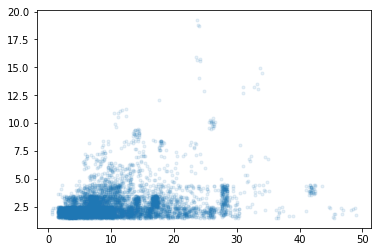

In [12]:
import random
plt.plot([x[0] + (random.random()-0.5) for x in plot_data if x[1]>1], [x[1] + (random.random()-0.5) for x in plot_data if x[1]>1], '.', alpha=0.1)
plt.show()

In [10]:
plot_data

[(2, 1),
 (6, 1),
 (8, 1),
 (8, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (4, 1),
 (4, 1),
 (4, 1),
 (3, 1),
 (3, 1),
 (22, 2),
 (7, 1),
 (6, 3),
 (5, 1),
 (6, 1),
 (6, 1),
 (9, 1),
 (14, 1),
 (14, 1),
 (2, 1),
 (28, 4),
 (28, 4),
 (28, 4),
 (28, 4),
 (15, 1),
 (5, 1),
 (5, 1),
 (6, 2),
 (4, 3),
 (6, 2),
 (5, 1),
 (5, 1),
 (5, 1),
 (19, 2),
 (19, 2),
 (19, 2),
 (19, 2),
 (3, 2),
 (5, 1),
 (5, 1),
 (11, 1),
 (4, 1),
 (6, 1),
 (6, 1),
 (6, 1),
 (6, 1),
 (6, 1),
 (6, 1),
 (6, 1),
 (8, 1),
 (8, 1),
 (4, 2),
 (5, 1),
 (5, 1),
 (9, 1),
 (4, 1),
 (32, 1),
 (1, 1),
 (1, 1),
 (5, 1),
 (9, 1),
 (5, 1),
 (5, 1),
 (9, 1),
 (23, 2),
 (6, 2),
 (11, 1),
 (5, 1),
 (5, 1),
 (5, 1),
 (5, 1),
 (5, 1),
 (5, 1),
 (1, 1),
 (1, 1),
 (14, 1),
 (1, 1),
 (4, 1),
 (14, 1),
 (4, 2),
 (14, 1),
 (8, 1),
 (5, 1),
 (2, 1),
 (2, 1),
 (13, 1),
 (5, 1),
 (6, 1),
 (4, 2),
 (1, 1),
 (2, 1),
 (2, 1),
 (13, 2),
 (13, 2),
 (6, 1),
 (1, 1),
 (21, 2),
 (10, 8),
 (6, 1),
 (21, 1),
 (21, 4),
 (20, 1),
 (5, 1),
 (11, 1),
 (5, 1),
 (1, 1),
